In [1]:
import requests
import json
import pandas as pd
import re
import time
import os
import random
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import nltk
from nltk.tokenize import word_tokenize
import csv

# Set up necessary directories and configurations:
os.makedirs('data', exist_ok=True)
session = requests.Session()
retries = Retry(total=3, backoff_factor=1, status_forcelist=[500, 502, 503, 504])
session.mount('http://', HTTPAdapter(max_retries=retries))
session.mount('https://', HTTPAdapter(max_retries=retries))
nltk.download('punkt')

# Clean title by standardizing the "By H. P. Lovecraft" text:
def clean_title(title):
    author_text = "By H. P. Lovecraft"
    title = re.sub(rf"({author_text}\s*)+", author_text, title).strip()
    if title.endswith(author_text) and not title.endswith(" " + author_text):
        title = title.replace(author_text, " " + author_text)
    return title

# --- Step 1: Scraping Lovecraft Fiction Works ---

def scrape_lovecraft_content():
    base_url = "https://www.hplovecraft.com/writings/texts/"
    response = session.get(base_url)
    
    if response.status_code != 200:
        print(f"Failed to access the base URL: {response.status_code}")
        return
    
    soup = BeautifulSoup(response.content, 'html.parser')
    content_links = [
        f"{base_url}{link['href']}"
        for link in soup.find_all('a', href=True)
        if link['href'].startswith('fiction/') and not link['href'].startswith('#')
    ]

    csv_filename = 'data/lovecraft_fiction.csv'
    with open(csv_filename, 'w', newline='', encoding='utf-8') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Content Type', 'Title', 'Text'])

        for content_url in content_links:
            time.sleep(random.uniform(1, 3))
            try:
                content_response = session.get(content_url, headers={'User-Agent': 'Mozilla/5.0'})
                if content_response.status_code == 200:
                    content_soup = BeautifulSoup(content_response.content, 'html.parser')
                    title_tag = content_soup.find('font', size="+2")
                    author_tag = content_soup.find('font', size="+1")
                    text_div = content_soup.find('div', align='justify')

                    if title_tag and text_div:
                        title = f"{title_tag.get_text(strip=True)} by {author_tag.get_text(strip=True)}"
                        title = clean_title(title)  # Clean the title text
                        csvwriter.writerow(["fiction", title, text_div.get_text(strip=True)])
                        print(f'Scraped: {title}')
                    else:
                        print(f'Title or text not found for {content_url}')
                else:
                    print(f'Failed to scrape {content_url}: {content_response.status_code}')
            except Exception as e:
                print(f'Error scraping {content_url}: {e}')

# Scrape only fiction content:
scrape_lovecraft_content()


[nltk_data] Downloading package punkt to C:\Users\Marc
[nltk_data]     Jay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Scraped: The AlchemistBy H. P. Lovecraftby By H. P. Lovecraft
Scraped: AshesBy C. M. Eddy, Jr.with H. P. Lovecraft by By C. M. Eddy, Jr.with H. P. Lovecraft
Scraped: At the Mountains of MadnessBy H. P. Lovecraftby By H. P. Lovecraft
Scraped: AzathothBy H. P. Lovecraftby By H. P. Lovecraft
Scraped: The Battle that Ended the Century(MS. Found in a Time Machine)By R. H. Barlowwith H. P. Lovecraft by (MS. Found in a Time Machine)By R. H. Barlowwith H. P. Lovecraft
Scraped: The Beast in the CaveBy H. P. Lovecraftby By H. P. Lovecraft
Scraped: Beyond the Wall of SleepBy H. P. Lovecraftby By H. P. Lovecraft
Scraped: The BookBy H. P. Lovecraftby By H. P. Lovecraft
Scraped: The Call of CthulhuBy H. P. Lovecraftby By H. P. Lovecraft
Scraped: The Case of Charles Dexter WardBy H. P. Lovecraftby By H. P. Lovecraft
Scraped: The Cats of UltharBy H. P. Lovecraftby By H. P. Lovecraft
Scraped: CelephaïsBy H. P. Lovecraftby By H. P. Lovecraft
Scraped: The Challenge from BeyondBy C.L. Moore, A. Merritt, H

In [16]:
# Load the scraped CSV data into a Pandas DataFrame
df = pd.read_csv('data/lovecraft_fiction.csv')

# View the first few rows of the dataframe to verify
print(df.head())


  Content Type                                              Title  \
0      fiction  The AlchemistBy H. P. Lovecraftby By H. P. Lov...   
1      fiction  AshesBy C. M. Eddy, Jr.with H. P. Lovecraft by...   
2      fiction  At the Mountains of MadnessBy H. P. Lovecraftb...   
3      fiction    AzathothBy H. P. Lovecraftby By H. P. Lovecraft   
4      fiction  The Battle that Ended the Century(MS. Found in...   

                                                Text  
0  High up, crowning the grassy summit of a swell...  
1  “Hello, Bruce. Haven’t seen you in a dog’s age...  
2  I.I am forced into speech because men of scien...  
3  When age fell upon the world, and wonder went ...  
4  [Note: Barlow’s contributions are in brackets....  


In [17]:
from nltk.corpus import stopwords

# Ensure stopwords are downloaded
nltk.download('stopwords')

# Tokenize and remove stopwords
def clean_text(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    cleaned_tokens = [word.lower() for word in tokens if word.isalnum() and word.lower() not in stop_words]
    return " ".join(cleaned_tokens)

# Apply to the text column in the dataframe
df['Cleaned_Text'] = df['Text'].apply(clean_text)


[nltk_data] Downloading package stopwords to C:\Users\Marc
[nltk_data]     Jay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
from collections import Counter

# Create a frequency distribution for words in all texts
all_words = " ".join(df['Cleaned_Text']).split()
word_freq = Counter(all_words)

# Display the most common words
print(word_freq.most_common(10))


[('could', 2306), ('one', 2056), ('would', 1815), ('old', 1367), ('seemed', 1165), ('time', 1126), ('great', 1039), ('even', 1033), ('must', 1003), ('man', 991)]


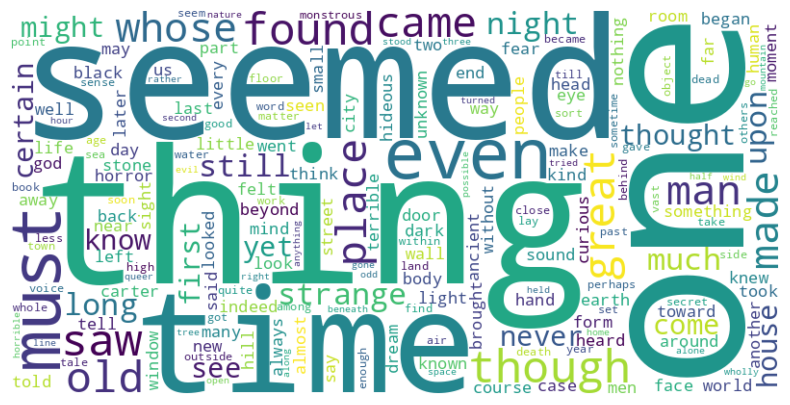

In [19]:
from wordcloud import WordCloud

# Create a word cloud from the cleaned text
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(df['Cleaned_Text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [20]:
import spacy
from collections import Counter

# Load the spaCy model for Named Entity Recognition
nlp = spacy.load("en_core_web_sm")

# Function to extract entities
def extract_entities(text):
    doc = nlp(text)
    entities = [ent.text.lower() for ent in doc.ents if ent.label_ in ['PERSON', 'ORG', 'GPE', 'LOC']]
    return entities

# Apply the extraction to the 'Cleaned_Text' column
df['Entities'] = df['Cleaned_Text'].apply(extract_entities)

# Flatten the list of entities and get their frequency count
all_entities = [entity for sublist in df['Entities'] for entity in sublist]
entity_freq = Counter(all_entities)

# Display the most common entities
print(entity_freq.most_common(100))


[('carter', 175), ('willett', 99), ('joseph curwen', 53), ('boston', 51), ('whateley', 45), ('arkham', 44), ('clarendon', 35), ('london', 33), ('new york', 32), ('africa', 26), ('vermont', 21), ('egypt', 20), ('johnny', 20), ('paris', 19), ('ammi', 19), ('denis', 19), ('europe', 17), ('mummy', 17), ('san francisco', 16), ('washington', 16), ('thou', 16), ('wolf', 15), ('cairo', 14), ('grey', 14), ('wilbur', 14), ('ben', 14), ('dobson', 14), ('california', 13), ('mexico city', 13), ('george campbell', 12), ('fed', 12), ('van der', 12), ('france', 11), ('us', 11), ('new orleans', 11), ('john brown', 11), ('randolph carter', 11), ('steve', 11), ('dalton', 11), ('joe slater', 10), ('america', 10), ('nahum', 10), ('moon', 10), ('davis', 10), ('wilbur whateley', 10), ('mexico', 10), ('de marigny', 10), ('rome', 9), ('gulf', 9), ('house olney court', 9), ('ezra weeden', 9), ('spain', 9), ('zoogs', 9), ('san quentin', 9), ('china', 9), ('kodak', 9), ('williams', 8), ('warren', 8), ('titan', 8)

In [21]:
# Custom list of Lovecraft entities to track
lovecraft_entities = [
    "cthulhu", "yog-sothoth", "nyarlathotep", "innsmouth", "arkham", "dunwich", "azathoth", "shub-niggurath",
    "hastur", "miskatonic", "the king in yellow", "the dark young", "the colour out of space", "the great old ones"
]

# Extract frequencies for these specific entities
specific_entity_freq = {entity: all_entities.count(entity) for entity in lovecraft_entities}

# Display the count of these specific entities
print(specific_entity_freq)


{'cthulhu': 0, 'yog-sothoth': 0, 'nyarlathotep': 0, 'innsmouth': 1, 'arkham': 44, 'dunwich': 0, 'azathoth': 0, 'shub-niggurath': 0, 'hastur': 0, 'miskatonic': 0, 'the king in yellow': 0, 'the dark young': 0, 'the colour out of space': 0, 'the great old ones': 0}


In [22]:
import spacy
import re
from collections import Counter

# Load the spaCy model for Named Entity Recognition
nlp = spacy.load("en_core_web_sm")

# Expanded list of Lovecraftian and related entities (including new ones)
lovecraft_entities_expanded = [
    "cthulhu", "great cthulhu", "yog-sothoth", "nyarlathotep", "innsmouth", "arkham", "dunwich", "azathoth",
    "shub-niggurath", "hastur", "miskatonic", "the king in yellow", "the dark young", "colour out of space",
    "the great old ones", "elder gods", "the old ones", "the deep ones", "night gaunts", "cthulhu cult",
    "the nameless city", "the black stone", "the dreamlands", "r'lyeh", "yog sothoth", "nyarlathotep",
    "dunwich horror", "the whisperer in darkness", "the colour out of space", "the shadow over innsmouth", "dagon",
    "the great intelligence", "fenric", "nestene consciousness", "guardians of time", "celestial toymaker", 
    "gods of ragnarok", "hecuba", "animus", "tor-gasukk", "moloch", "kai'lizakia", "lloigor", "toymakers",
    "eidolon", "derleth", "gog and magog", "to'koth", "karnas'koi", "traguam", "archon", "mi'en kalarash", 
    "kwundaar", "volund"
]

# Function to extract entities
def extract_entities(text):
    doc = nlp(text)
    
    # Initialize the list to store extracted entities
    entities = []
    
    # Extract the named entities using spaCy's NER (PERSON, ORG, GPE, LOC)
    for ent in doc.ents:
        if ent.label_ in ['PERSON', 'ORG', 'GPE', 'LOC']:
            entities.append(ent.text.lower())
    
    # Manually add expanded entities and regex pattern matches for indirect references
    for entity in lovecraft_entities_expanded:
        # Check for direct entity mentions (singular and plural)
        singular_entity = r'\b' + re.escape(entity) + r'\b'
        plural_entity = r'\b' + re.escape(entity + "s") + r'\b'  # Handle plural form

        if re.search(singular_entity, text.lower()) or re.search(plural_entity, text.lower()):
            entities.append(entity)
        
        # Check for indirect references or variations (e.g., "great old ones" or "eldritch horror")
        indirect_references = [
            r"\bdeep ones\b", r"\bcosmic entity\b", r"\bhorrible being\b", r"\bnight gaunts\b", r"\bblack stone\b",
            r"\byog sothoth\b", r"\bnamesless city\b", r"\bstrange entity\b", r"\botherworldly creature\b", r"\bdark god\b",
            r"\bhorrible power\b", r"\btimeless one\b"
        ]
        for pattern in indirect_references:
            if re.search(pattern, text.lower()):
                entities.append(entity)
    
    return entities

# Apply the extraction to the 'Cleaned_Text' column (assuming 'Cleaned_Text' contains the content)
df['Entities'] = df['Cleaned_Text'].apply(extract_entities)

# Flatten the list of entities and get their frequency count
all_entities = [entity for sublist in df['Entities'] for entity in sublist]
entity_freq = Counter(all_entities)

# Display the most common entities
print(entity_freq.most_common(100))

# Custom list of Lovecraft entities to track (including new entities)
specific_entity_freq = {entity: all_entities.count(entity) for entity in lovecraft_entities_expanded}

# Display the count of these specific entities
print(specific_entity_freq)


[('carter', 175), ('willett', 99), ('arkham', 73), ('joseph curwen', 53), ('boston', 51), ('whateley', 45), ('nyarlathotep', 40), ('clarendon', 35), ('london', 33), ('new york', 32), ('africa', 26), ('miskatonic', 26), ('cthulhu', 21), ('vermont', 21), ('egypt', 20), ('johnny', 20), ('paris', 19), ('ammi', 19), ('denis', 19), ('europe', 17), ('great cthulhu', 17), ('innsmouth', 17), ('azathoth', 17), ('eidolon', 17), ('mummy', 17), ('elder gods', 16), ('dagon', 16), ('san francisco', 16), ('washington', 16), ('thou', 16), ('wolf', 15), ('cthulhu cult', 14), ('cairo', 14), ('grey', 14), ('wilbur', 14), ('ben', 14), ('dobson', 14), ('dunwich', 13), ('hastur', 13), ('dunwich horror', 13), ('moloch', 13), ('derleth', 13), ('archon', 13), ('california', 13), ('mexico city', 13), ('yog-sothoth', 12), ('shub-niggurath', 12), ('the king in yellow', 12), ('the dark young', 12), ('colour out of space', 12), ('the great old ones', 12), ('the old ones', 12), ('the deep ones', 12), ('night gaunts',

In [23]:
# List of entities with their mentions
entities = [
    ('cthulhu', 21), ('great cthulhu', 17), ('yog-sothoth', 12), ('nyarlathotep', 40),
    ('innsmouth', 17), ('arkham', 73), ('dunwich', 13), ('azathoth', 17), ('shub-niggurath', 12),
    ('hastur', 13), ('miskatonic', 26), ('the king in yellow', 12), ('the dark young', 12),
    ('colour out of space', 12), ('the great old ones', 12), ('elder gods', 16), ('the old ones', 12),
    ('the deep ones', 12), ('night gaunts', 12), ('cthulhu cult', 14), ('the nameless city', 12),
    ('the black stone', 12), ('the dreamlands', 12), ("r'lyeh", 12), ('yog sothoth', 12),
    ('dunwich horror', 13), ('the whisperer in darkness', 12), ('the colour out of space', 12),
    ('the shadow over innsmouth', 12), ('dagon', 16), ('the great intelligence', 12), ('fenric', 12),
    ('nestene consciousness', 12), ('guardians of time', 12), ('celestial toymaker', 12),
    ('gods of ragnarok', 12), ('hecuba', 12), ('animus', 12), ('tor-gasukk', 12), ('moloch', 13),
    ("kai'lizakia", 12), ('lloigor', 12), ('toymakers', 12), ('eidolon', 17), ('derleth', 13),
    ('gog and magog', 12), ("to'koth", 12), ("karnas'koi", 12), ('traguam', 12), ('archon', 13),
    ("mi'en kalarash", 12), ('kwundaar', 12), ('volund', 12), ('joseph curwen', 53), ('boston', 51),
    ('whateley', 45), ('clarendon', 35), ('london', 33), ('new york', 32), ('africa', 26), 
    ('johnny', 20), ('paris', 19), ('ammi', 19), ('denis', 19), ('europe', 17), ('wilbur', 14),
    ('ben', 14), ('dobson', 14), ('california', 13), ('mexico city', 13), ('yog-sothoth', 12),
    ('shub-niggurath', 12), ('the king in yellow', 12), ('the dark young', 12), ('colour out of space', 12),
    ('the great old ones', 12), ('the old ones', 12), ('the deep ones', 12), ('night gaunts', 12),
    ('the nameless city', 12), ('the black stone', 12), ('the dreamlands', 12), ("r'lyeh", 12), 
    ('yog sothoth', 12), ('the whisperer in darkness', 12), ('the colour out of space', 12), 
    ('the shadow over innsmouth', 12), ('the great intelligence', 12), ('fenric', 12), 
    ('nestene consciousness', 12), ('guardians of time', 12), ('celestial toymaker', 12), 
    ('gods of ragnarok', 12), ('hecuba', 12), ('animus', 12), ('tor-gasukk', 12), ("kai'lizakia", 12),
    ('lloigor', 12), ('toymakers', 12), ('eidolon', 17), ('derleth', 13), ('gog and magog', 12),
    ("to'koth", 12), ("karnas'koi", 12), ('traguam', 12), ('archon', 13), ("mi'en kalarash", 12),
    ('kwundaar', 12), ('volund', 12)
]

# List of human names to exclude
human_names = ['joseph curwen', 'johnny', 'ammi', 'denis', 'wilbur', 'ben', 'dobson', 'george campbell',
               'steve', 'dalton', 'joe slater', 'randolph carter', 'john brown', 'de marigny', 'wilbur whateley']

# Function to filter and categorize entities
def filter_lovecraft_entities(entities, exclude_humans=True):
    # Create a dictionary to store entities by category
    categories = {
        'Cthulhu Mythos': [],
        'Locations & Settings': [],
        'Cosmic Entities': [],
        'Occult Entities': [],
        'Mythos-Related Concepts': []
    }
    
    # Process each entity in the list
    for entity, mentions in entities:
        # Exclude human characters
        if exclude_humans and entity.lower() in human_names:
            continue
        
        # Categorize entities based on their known groupings
        if entity in ['cthulhu', 'great cthulhu', 'nyarlathotep', 'azathoth', 'shub-niggurath', 'dagon', 'yog-sothoth']:
            categories['Cthulhu Mythos'].append((entity, mentions))
        elif entity in ['arkham', 'miskatonic', 'innsmouth', 'dunwich', 'r\'lyeh', 'the dreamlands', 'the nameless city']:
            categories['Locations & Settings'].append((entity, mentions))
        elif entity in ['elder gods', 'the old ones', 'the great old ones', 'night gaunts', 'the deep ones', 'colour out of space', 'yog sothoth']:
            categories['Cosmic Entities'].append((entity, mentions))
        elif entity in ['toymakers', 'guardians of time', 'the great intelligence', 'moloch', 'hecuba', 'animus', 'archon']:
            categories['Occult Entities'].append((entity, mentions))
        else:
            categories['Mythos-Related Concepts'].append((entity, mentions))
    
    return categories

# Apply the filter
filtered_entities = filter_lovecraft_entities(entities)

# Print the result
for category, entities_list in filtered_entities.items():
    print(f"--- {category} ---")
    for entity, mentions in entities_list:
        print(f"{entity}: {mentions}")


--- Cthulhu Mythos ---
cthulhu: 21
great cthulhu: 17
yog-sothoth: 12
nyarlathotep: 40
azathoth: 17
shub-niggurath: 12
dagon: 16
yog-sothoth: 12
shub-niggurath: 12
--- Locations & Settings ---
innsmouth: 17
arkham: 73
dunwich: 13
miskatonic: 26
the nameless city: 12
the dreamlands: 12
r'lyeh: 12
the nameless city: 12
the dreamlands: 12
r'lyeh: 12
--- Cosmic Entities ---
colour out of space: 12
the great old ones: 12
elder gods: 16
the old ones: 12
the deep ones: 12
night gaunts: 12
yog sothoth: 12
colour out of space: 12
the great old ones: 12
the old ones: 12
the deep ones: 12
night gaunts: 12
yog sothoth: 12
--- Occult Entities ---
the great intelligence: 12
guardians of time: 12
hecuba: 12
animus: 12
moloch: 13
toymakers: 12
archon: 13
the great intelligence: 12
guardians of time: 12
hecuba: 12
animus: 12
toymakers: 12
archon: 13
--- Mythos-Related Concepts ---
hastur: 13
the king in yellow: 12
the dark young: 12
cthulhu cult: 14
the black stone: 12
dunwich horror: 13
the whisperer i